# DS-GS1011 nlp_Assignment 1_ Python Code Appendix

__Student Name:__ Wenting Qi

__Net ID:__ wq244

In [27]:
import os
import random
import spacy
import string
import torch
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


## Section 1 Bag of Mono-gram Model
### Baseline Model

In [3]:
# get directory of the data
os.chdir("/Users/NicoleQi/Desktop/NYU/DS1011/Assignment/1")
cwd = os.getcwd()
print(cwd)
datadir = cwd+'/aclImdb'
print(datadir)

/Users/NicoleQi/Desktop/NYU/DS1011/Assignment/1
/Users/NicoleQi/Desktop/NYU/DS1011/Assignment/1/aclImdb


In [217]:
# Load negative training data and score targets
aclImdb_train_data_neg = []
aclImdb_train_scoretarget_neg = []

os.chdir(datadir+'/train/neg')
for file in os.listdir():
    text_file = open(file,'r')
    aclImdb_train_data_neg.append(text_file.read())    
    aclImdb_train_scoretarget_neg.append(int(file[:-4].split('_')[-1]))
    text_file.close()

    

# Load positive training data and score targets
aclImdb_train_data_pos = []
aclImdb_train_scoretarget_pos = []

os.chdir(datadir+'/train/pos')
for file in os.listdir():
    text_file = open(file,'r')
    aclImdb_train_data_pos.append(text_file.read())    
    aclImdb_train_scoretarget_pos.append(int(file[:-4].split('_')[-1]))
    text_file.close()


# Load negative testing data and score targets
aclImdb_test_data_neg = []
aclImdb_test_scoretarget_neg = []

os.chdir(datadir+'/test/neg')
for file in os.listdir():
    text_file = open(file,'r')
    aclImdb_test_data_neg.append(text_file.read())    
    aclImdb_test_scoretarget_neg.append(int(file[:-4].split('_')[-1]))
    text_file.close()

# Load positive testing data and score targets

aclImdb_test_data_pos = []
aclImdb_test_scoretarget_pos = []

os.chdir(datadir+'/test/pos')
for file in os.listdir():
    text_file = open(file,'r')
    aclImdb_test_data_pos.append(text_file.read())    
    aclImdb_test_scoretarget_pos.append(int(file[:-4].split('_')[-1]))
    text_file.close()


In [218]:
# Split train data into training set and validation set
# Union the positive and negative data 

train_split = int(len(aclImdb_train_data_neg)*0.8)

train_data = aclImdb_train_data_neg[:train_split] + aclImdb_train_data_pos[:train_split]
train_target = [0]*train_split + [1]*train_split
train_scoretarget = aclImdb_train_scoretarget_neg[:train_split] + aclImdb_train_scoretarget_pos[:train_split]

val_data = aclImdb_train_data_neg[train_split:] + aclImdb_train_data_pos[train_split:]
val_target = [0]*len(aclImdb_train_data_neg[train_split:]) + [1]*len(aclImdb_train_data_pos[train_split:])
val_scoretarget = aclImdb_train_scoretarget_neg[train_split:] + aclImdb_train_scoretarget_pos[train_split:]

test_data = aclImdb_test_data_neg + aclImdb_test_data_pos
test_target = [0]*len(aclImdb_test_data_neg) + [1]*len(aclImdb_test_data_pos)
test_scoretarget = aclImdb_test_scoretarget_neg + aclImdb_test_scoretarget_pos


In [6]:
# Define tokenize function

tokenizer = spacy.load('en_core_web_sm')
puncs = string.punctuation
Stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def tokenize(s):
    token = tokenizer(s)
    tokenized = []
    for i in token:
        if i.text not in puncs:
            tokenized.append(i.text.lower())
    return tokenized

# Normal BOW tokenize function
def BOW_tokenize(data):
    token_dataset = []
    BOW_tokens = []
    for i in data:
        tokens = tokenize(i)
        token_dataset.append(tokens)
        BOW_tokens += tokens
    return token_dataset,BOW_tokens



In [ ]:
# Tokenize the train/validation/test set using Bag of Words when N=1
mono_train_data_tokens, BOW_tokens = BOW_tokenize(train_data)
mono_val_data_tokens, _ = BOW_tokenize(val_data)
mono_test_data_tokens, _ = BOW_tokenize(test_data)


In [136]:
'''
# Save tokenized dataset
os.chdir(datadir)
pkl.dump(mono_train_data_tokens, open("mono_train_data_tokens.p", "wb"))
pkl.dump(BOW_tokens, open("BOW_tokens.p", "wb"))
pkl.dump(mono_val_data_tokens, open("mono_val_data_tokens.p", "wb"))
pkl.dump(mono_test_data_tokens, open("mono_test_data_tokens.p", "wb"))

In [7]:
'''
# Load tokenized dataset from local
os.chdir(datadir)
mono_train_data_tokens = pkl.load(open("mono_train_data_tokens.p", "rb"))
BOW_tokens = pkl.load(open("BOW_tokens.p", "rb"))

mono_val_data_tokens = pkl.load(open("mono_val_data_tokens.p", "rb"))
mono_test_data_tokens = pkl.load(open("mono_test_data_tokens.p", "rb"))

In [9]:
# Build Vocabulary
max_vocab_size_1 = 10000
pad_idx = 0
unk_idx = 1

def build_vocab(tokens, max_vocab_size):
    token_counter = Counter(tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    vocab = ['<pad>','<unk>'] + list(vocab)
    token2id = {}
    for i,t in enumerate(vocab):
        token2id[t] = i
    return token2id, vocab

BOW_token2id, BOW_vocab= build_vocab(BOW_tokens, max_vocab_size_1)

In [10]:
# convert token to id in the dataset
def indices_dataset(tokens_data, token_dic):
    indices_data = []
    for token in tokens_data:
        index_list = [token_dic[t] if t in token_dic else unk_idx for t in token]
        indices_data.append(index_list)
    return indices_data

mono_train_data_indices = indices_dataset(mono_train_data_tokens, BOW_token2id)
mono_val_data_indices = indices_dataset(mono_val_data_tokens, BOW_token2id)
mono_test_data_indices = indices_dataset(mono_test_data_tokens, BOW_token2id)

In [12]:
# Build dataset and pad all input to same length
max_sentence_length = 200

class aclImdbDataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, key):
        token_index = self.data_list[key][:max_sentence_length]
        label = self.target_list[key]
        return [token_index, len(token_index), label]


In [13]:
def collate_func(batch):
    data_list = []
    length_list = []
    target_list = []
    
    for datum in batch:
        length_list.append(datum[1])
        target_list.append(datum[2])
    
    for datum in batch:
        padding_data = np.pad(np.array(datum[0]),pad_width=((0,max_sentence_length-datum[1])), mode='constant',constant_values=pad_idx)
        data_list.append(padding_data)
    return [torch.from_numpy(np.array(data_list)),torch.LongTensor(length_list), torch.LongTensor(target_list)]

In [14]:
BATCH_SIZE = 64
mono_train_dataset = aclImdbDataset(mono_train_data_indices, train_target)
mono_train_loader = torch.utils.data.DataLoader(dataset=mono_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_val_dataset = aclImdbDataset(mono_val_data_indices, val_target)
mono_val_loader = torch.utils.data.DataLoader(dataset=mono_val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_test_dataset = aclImdbDataset(mono_test_data_indices, test_target)
mono_test_loader = torch.utils.data.DataLoader(dataset=mono_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [15]:
# Build Bag of NGram baseline Model
class BagOfNGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BagOfNGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim,128)
    
    def forward(self, data, length):
        out = self.embeddings(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        out = self.linear(out.float())
        return out

        

In [16]:
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += data.size(0)
    return (100*correct/total)

### Model I

In [17]:
t0 = time.time()
val_acc_epochs_SGD_1 = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_SGD_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))
t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 53.68
Epoch: [1/5], Step: [201/313], Validation Acc: 55.42
Epoch: [1/5], Step: [301/313], Validation Acc: 57.82
Epoch: [2/5], Step: [101/313], Validation Acc: 58.98
Epoch: [2/5], Step: [201/313], Validation Acc: 56.28
Epoch: [2/5], Step: [301/313], Validation Acc: 60.1
Epoch: [3/5], Step: [101/313], Validation Acc: 58.04
Epoch: [3/5], Step: [201/313], Validation Acc: 60.72
Epoch: [3/5], Step: [301/313], Validation Acc: 62.22
Epoch: [4/5], Step: [101/313], Validation Acc: 60.3
Epoch: [4/5], Step: [201/313], Validation Acc: 61.94
Epoch: [4/5], Step: [301/313], Validation Acc: 61.76
Epoch: [5/5], Step: [101/313], Validation Acc: 62.72
Epoch: [5/5], Step: [201/313], Validation Acc: 61.22
Epoch: [5/5], Step: [301/313], Validation Acc: 61.38
Time elapse: 70.80317902565002


### Model II

In [ ]:
t0 = time.time()
val_acc_epochs_SGD_10 = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.10
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_SGD_10.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))
        
t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

### Model III

In [62]:
t0 = time.time()
val_acc_epochs_SGD_20 = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.20
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_SGD_20.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))
    
t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 51.34
Epoch: [1/5], Step: [201/313], Validation Acc: 55.58
Epoch: [1/5], Step: [301/313], Validation Acc: 52.06
Epoch: [2/5], Step: [101/313], Validation Acc: 57.92
Epoch: [2/5], Step: [201/313], Validation Acc: 59.08
Epoch: [2/5], Step: [301/313], Validation Acc: 56.28
Epoch: [3/5], Step: [101/313], Validation Acc: 64.0
Epoch: [3/5], Step: [201/313], Validation Acc: 57.12
Epoch: [3/5], Step: [301/313], Validation Acc: 61.4
Epoch: [4/5], Step: [101/313], Validation Acc: 60.92
Epoch: [4/5], Step: [201/313], Validation Acc: 64.48
Epoch: [4/5], Step: [301/313], Validation Acc: 60.12
Epoch: [5/5], Step: [101/313], Validation Acc: 64.64
Epoch: [5/5], Step: [201/313], Validation Acc: 66.26
Epoch: [5/5], Step: [301/313], Validation Acc: 64.62
Time elapse: 66.47437596321106


Text(0,0.5,'Validation Accuracy')

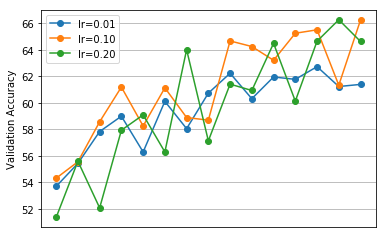

In [63]:
lr_1=plt.plot(val_acc_epochs_SGD_1, marker='o', label='lr=0.01')
lr_10=plt.plot(val_acc_epochs_SGD_10, marker='o', label='lr=0.10')
lr_15=plt.plot(val_acc_epochs_SGD_20, marker='o', label='lr=0.20')

plt.legend(loc=2)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs for Various Learning Rate')

### Model IV

In [57]:
t0 = time.time()
val_acc_epochs_SGD_10_step = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.1
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, gamma = 0.8, step_size=3)


for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_SGD_10_step.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))
    
    
t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 53.16
Epoch: [1/5], Step: [201/313], Validation Acc: 57.3
Epoch: [1/5], Step: [301/313], Validation Acc: 60.7
Epoch: [2/5], Step: [101/313], Validation Acc: 56.64
Epoch: [2/5], Step: [201/313], Validation Acc: 57.82
Epoch: [2/5], Step: [301/313], Validation Acc: 60.54
Epoch: [3/5], Step: [101/313], Validation Acc: 59.22
Epoch: [3/5], Step: [201/313], Validation Acc: 64.94
Epoch: [3/5], Step: [301/313], Validation Acc: 65.26
Epoch: [4/5], Step: [101/313], Validation Acc: 60.54
Epoch: [4/5], Step: [201/313], Validation Acc: 65.34
Epoch: [4/5], Step: [301/313], Validation Acc: 61.5
Epoch: [5/5], Step: [101/313], Validation Acc: 63.9
Epoch: [5/5], Step: [201/313], Validation Acc: 64.4
Epoch: [5/5], Step: [301/313], Validation Acc: 65.72
Time elapse: 69.62148809432983


### Model V

In [ ]:


t0 = time.time()
val_acc_epochs_SGD_10_lambda = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.10
num_epochs = 5
lambda1 = lambda epoch: 0.8 ** epoch
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_SGD_10_lambda.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))
    
t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Text(0,0.5,'Validation Accuracy')

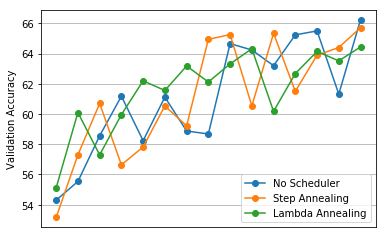

In [61]:
lr_1=plt.plot(val_acc_epochs_SGD_10, marker='o', label='No Scheduler')
lr_10=plt.plot(val_acc_epochs_SGD_10_step, marker='o', label='Step Annealing')
lr_15=plt.plot(val_acc_epochs_SGD_10_lambda, marker='o', label='Lambda Annealing')

plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

### Model VI

In [69]:
t0 = time.time()
val_acc_epochs_Adam_1 = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.8 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader, model)
            val_acc_epochs_Adam_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 76.66
Epoch: [1/5], Step: [201/313], Validation Acc: 83.0
Epoch: [1/5], Step: [301/313], Validation Acc: 85.22
Epoch: [2/5], Step: [101/313], Validation Acc: 86.88
Epoch: [2/5], Step: [201/313], Validation Acc: 86.92
Epoch: [2/5], Step: [301/313], Validation Acc: 87.08
Epoch: [3/5], Step: [101/313], Validation Acc: 86.3
Epoch: [3/5], Step: [201/313], Validation Acc: 85.42
Epoch: [3/5], Step: [301/313], Validation Acc: 87.12
Epoch: [4/5], Step: [101/313], Validation Acc: 87.26
Epoch: [4/5], Step: [201/313], Validation Acc: 87.0
Epoch: [4/5], Step: [301/313], Validation Acc: 86.7
Epoch: [5/5], Step: [101/313], Validation Acc: 86.42
Epoch: [5/5], Step: [201/313], Validation Acc: 86.64
Epoch: [5/5], Step: [301/313], Validation Acc: 86.9
Time elapse: 79.69887280464172


Text(0,0.5,'Validation Accuracy')

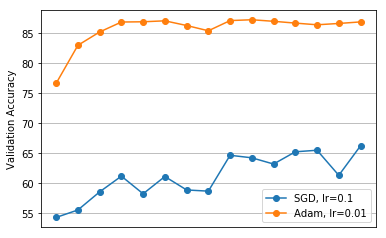

In [70]:
sgd=plt.plot(val_acc_epochs_SGD_10, marker='o', label='SGD, lr=0.1')
adam=plt.plot(val_acc_epochs_Adam_1, marker='o', label='Adam, lr=0.01')


plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

### Model VII

In [71]:
# double the vocab size
max_vocab_size_2 = 20000
BOW_token2id_L, BOW_vocab_L= build_vocab(BOW_tokens, max_vocab_size_2)
mono_train_data_indices_L = indices_dataset(mono_train_data_tokens, BOW_token2id_L)
mono_val_data_indices_L = indices_dataset(mono_val_data_tokens, BOW_token2id_L)
mono_test_data_indices_L = indices_dataset(mono_test_data_tokens, BOW_token2id_L)

In [72]:
mono_train_dataset_L = aclImdbDataset(mono_train_data_indices_L, train_target)
mono_train_loader_L = torch.utils.data.DataLoader(dataset=mono_train_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_val_dataset_L = aclImdbDataset(mono_val_data_indices_L, val_target)
mono_val_loader_L = torch.utils.data.DataLoader(dataset=mono_val_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_test_dataset_L = aclImdbDataset(mono_test_data_indices_L, test_target)
mono_test_loader_L = torch.utils.data.DataLoader(dataset=mono_test_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [73]:
t0 = time.time()
val_acc_epochs_Adam_L = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.8 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader_L, model)
            val_acc_epochs_Adam_L.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader_L), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 75.48
Epoch: [1/5], Step: [201/313], Validation Acc: 83.56
Epoch: [1/5], Step: [301/313], Validation Acc: 81.16
Epoch: [2/5], Step: [101/313], Validation Acc: 86.98
Epoch: [2/5], Step: [201/313], Validation Acc: 87.02
Epoch: [2/5], Step: [301/313], Validation Acc: 86.36
Epoch: [3/5], Step: [101/313], Validation Acc: 87.48
Epoch: [3/5], Step: [201/313], Validation Acc: 87.5
Epoch: [3/5], Step: [301/313], Validation Acc: 87.46
Epoch: [4/5], Step: [101/313], Validation Acc: 87.58
Epoch: [4/5], Step: [201/313], Validation Acc: 87.92
Epoch: [4/5], Step: [301/313], Validation Acc: 87.86
Epoch: [5/5], Step: [101/313], Validation Acc: 87.44
Epoch: [5/5], Step: [201/313], Validation Acc: 87.52
Epoch: [5/5], Step: [301/313], Validation Acc: 87.58
Time elapse: 92.1236572265625


### Model VIII

In [74]:
t0 = time.time()
val_acc_epochs_Adam_L_200 = []

emb_dim = 200
model = BagOfNGram(len(BOW_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.8 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader_L, model)
            val_acc_epochs_Adam_L_200.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader_L), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 78.08
Epoch: [1/5], Step: [201/313], Validation Acc: 84.56
Epoch: [1/5], Step: [301/313], Validation Acc: 83.74
Epoch: [2/5], Step: [101/313], Validation Acc: 86.92
Epoch: [2/5], Step: [201/313], Validation Acc: 86.5
Epoch: [2/5], Step: [301/313], Validation Acc: 87.24
Epoch: [3/5], Step: [101/313], Validation Acc: 87.28
Epoch: [3/5], Step: [201/313], Validation Acc: 86.98
Epoch: [3/5], Step: [301/313], Validation Acc: 86.4
Epoch: [4/5], Step: [101/313], Validation Acc: 87.48
Epoch: [4/5], Step: [201/313], Validation Acc: 86.92
Epoch: [4/5], Step: [301/313], Validation Acc: 86.58
Epoch: [5/5], Step: [101/313], Validation Acc: 86.84
Epoch: [5/5], Step: [201/313], Validation Acc: 86.72
Epoch: [5/5], Step: [301/313], Validation Acc: 86.72
Time elapse: 125.08107304573059


Text(0,0.5,'Validation Accuracy')

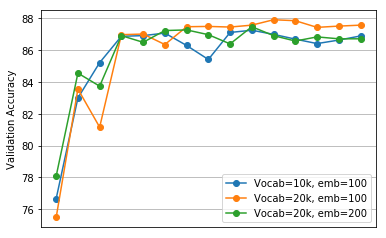

In [75]:
adam=plt.plot(val_acc_epochs_Adam_1, marker='o', label='Vocab=10k, emb=100')
adam_L=plt.plot(val_acc_epochs_Adam_L, marker='o', label='Vocab=20k, emb=100')
adam_L_200=plt.plot(val_acc_epochs_Adam_L_200, marker='o', label='Vocab=20k, emb=200')


plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

### Model IX

In [354]:
# Define BOW tokenize function with stemming and stopwords cleaning
def BOW_tokenize_plus(data):
    token_dataset = []
    BOW_tokens = []
    for i in data:
        tokens = tokenize(i)
        tokensFiltered = []
        for words in tokens:  
            if str(words) not in Stopwords:
                tokensFiltered.append(ps.stem(words))
        token_dataset.append(tokensFiltered)
        BOW_tokens += tokensFiltered
    return token_dataset,BOW_tokens

# Advanced tokenize the train/validation/test set using Bag of Words when N=1
mono_train_data_tokens_plus, BOW_tokens_plus = BOW_tokenize_plus(train_data)
mono_val_data_tokens_plus, _ = BOW_tokenize_plus(val_data)
mono_test_data_tokens_plus, _ = BOW_tokenize_plus(test_data)

In [355]:
'''
os.chdir(datadir)
pkl.dump(mono_train_data_tokens_plus, open("mono_train_data_tokens_plus.p", "wb"))
pkl.dump(BOW_tokens_plus, open("BOW_tokens_plus.p", "wb"))
pkl.dump(mono_val_data_tokens_plus, open("mono_val_data_tokens_plus.p", "wb"))
pkl.dump(mono_test_data_tokens_plus, open("mono_test_data_tokens_plus.p", "wb"))

In [8]:
'''
os.chdir(datadir)
mono_train_data_tokens_plus = pkl.load(open("mono_train_data_tokens_plus.p", "rb"))
BOW_tokens_plus = pkl.load(open("BOW_tokens_plus.p", "rb"))

mono_val_data_tokens_plus = pkl.load(open("mono_val_data_tokens_plus.p", "rb"))
mono_test_data_tokens_plus = pkl.load(open("mono_test_data_tokens_plus.p", "rb"))

In [76]:
# Index data according to the new tokenization scheme
BOW_token2id_plus, BOW_vocab_plus= build_vocab(BOW_tokens_plus, max_vocab_size_2)

mono_train_data_indices_plus = indices_dataset(mono_train_data_tokens_plus, BOW_token2id_plus)
mono_val_data_indices_plus = indices_dataset(mono_val_data_tokens_plus, BOW_token2id_plus)
mono_test_data_indices_plus = indices_dataset(mono_test_data_tokens_plus, BOW_token2id_plus)

BATCH_SIZE = 64
mono_train_dataset_plus = aclImdbDataset(mono_train_data_indices_plus, train_target)
mono_train_loader_plus = torch.utils.data.DataLoader(dataset=mono_train_dataset_plus, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_val_dataset_plus = aclImdbDataset(mono_val_data_indices_plus, val_target)
mono_val_loader_plus = torch.utils.data.DataLoader(dataset=mono_val_dataset_plus, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_test_dataset_plus = aclImdbDataset(mono_test_data_indices_plus, test_target)
mono_test_loader_plus = torch.utils.data.DataLoader(dataset=mono_test_dataset_plus, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [213]:
t0 = time.time()
val_acc_epochs_Adam_L_plus = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id_plus),emb_dim)
learning_rate = 0.01
num_epochs = 4
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.8 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(mono_train_loader_plus):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_loader_plus, model)
            val_acc_epochs_Adam_L_plus.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_loader_plus), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

Epoch: [1/4], Step: [101/313], Validation Acc: 76.02
Epoch: [1/4], Step: [201/313], Validation Acc: 86.08
Epoch: [1/4], Step: [301/313], Validation Acc: 87.2
Epoch: [2/4], Step: [101/313], Validation Acc: 88.06
Epoch: [2/4], Step: [201/313], Validation Acc: 88.22
Epoch: [2/4], Step: [301/313], Validation Acc: 88.36
Epoch: [3/4], Step: [101/313], Validation Acc: 88.8
Epoch: [3/4], Step: [201/313], Validation Acc: 88.7
Epoch: [3/4], Step: [301/313], Validation Acc: 88.16
Epoch: [4/4], Step: [101/313], Validation Acc: 88.2
Epoch: [4/4], Step: [201/313], Validation Acc: 88.48
Epoch: [4/4], Step: [301/313], Validation Acc: 87.98
Time elapse: 72.07290697097778


In [204]:
# Define a function that shows the three correct perdiction
def three_correct_perdict(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        i = 0
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correct = list(predicted.eq(labels.view_as(predicted)))
        indices_data = list(data_batch)
        label_target = list(label_batch)
        if correct[i] == 1:
            print('Data: {}, Label: {}, Predicted: {}'.format(list(indices_data[i].numpy()),label_target[i],predicted[i]))
            total += 1
            if total == 3:
                break
        else:
            i += 1
    return 

In [205]:
three_correct_perdict(mono_val_loader_plus, model)

Data: [169, 4, 873, 222, 14, 38, 8550, 7944, 891, 113, 10771, 3525, 238, 2, 2029, 3289, 277, 804, 628, 238, 2, 2358, 384, 17840, 2208, 368, 939, 861, 195, 2321, 33, 215, 348, 1868, 411, 12835, 1984, 15101, 1, 33, 1101, 71, 17, 35, 2727, 611, 982, 138, 493, 249, 1572, 6471, 19690, 1829, 797, 573, 549, 97, 2624, 7469, 14903, 17, 129, 29, 128, 986, 4, 78, 1, 1, 184, 164, 3695, 11702, 2, 14, 6453, 171, 164, 11458, 23, 1, 3, 43, 13621, 21, 4342, 685, 28, 66, 4579, 21, 591, 163, 108, 3394, 18396, 158, 20, 35, 15, 339, 5710, 7944, 820, 1, 3686, 18225, 8390, 1, 184, 2661, 1118, 49, 7, 6919, 3394, 18396, 33, 1784, 174, 410, 13621, 617, 697, 264, 2227, 3, 43, 124, 442, 136, 527, 1175, 5, 4286, 2915, 918, 59, 1059, 8, 105, 1276, 261, 41, 3, 559, 47, 442, 27, 283, 434, 368, 7, 404, 4298, 11702, 49, 6038, 653, 301, 257, 819, 127, 2, 417, 45, 5202, 10900, 3, 43, 1276, 20, 158, 18396, 1577, 390, 12, 365, 789, 364, 2915, 390, 7, 157, 295, 334, 71, 269, 945, 55, 270, 4, 0, 0, 0, 0, 0, 0, 0], Label: 0, 

In [211]:
# Define a function that shows three incorrect prediction
def three_incorrect_perdict(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        i = 0
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correct = list(predicted.eq(labels.view_as(predicted)))
        indices_data = list(data_batch)
        label_target = list(label_batch)
        if correct[i] != 1:
            print('Data: {}, Label: {}, Predicted: {}'.format(list(indices_data[i].numpy()),label_target[i],predicted[i]))
            total += 1
            if total == 3:
                break
        else:
            i += 1
    return 

In [212]:
three_incorrect_perdict(mono_val_loader_plus, model)

Data: [3281, 593, 12220, 149, 155, 10480, 179, 7, 319, 3164, 733, 28, 868, 9, 70, 1514, 18093, 11126, 156, 3164, 421, 1, 3, 1, 1132, 3018, 11103, 31, 117, 257, 617, 957, 142, 847, 1823, 1, 497, 563, 403, 1063, 1530, 111, 6, 402, 7611, 593, 243, 7532, 47, 445, 140, 1, 3, 11307, 1530, 7481, 17784, 861, 13, 737, 8774, 81, 321, 55, 22, 481, 35, 9, 1539, 1063, 8627, 78, 2972, 62, 583, 11932, 213, 575, 15037, 10478, 1200, 169, 12774, 3, 11173, 26, 323, 200, 323, 6462, 382, 49, 697, 6, 46, 86, 213, 96, 7, 1, 7, 215, 188, 93, 209, 1597, 815, 30, 96, 1147, 27, 9338, 1543, 1063, 26, 19, 1, 3, 43, 5, 192, 210, 2454, 3430, 1131, 50, 635, 2501, 14, 38, 10, 1063, 1530, 6373, 5347, 990, 363, 135, 123, 38, 1576, 539, 1131, 759, 14, 735, 3364, 79, 1235, 6373, 104, 1880, 1530, 6600, 14150, 36, 11118, 1534, 291, 7, 1530, 97, 1675, 38, 1, 1, 201, 5697, 1346, 3026, 690, 3336, 31, 4307, 6983, 38, 1, 6, 25, 6173, 3, 43, 5, 7422, 1368, 524, 6922, 15548, 635, 655, 10, 5, 196, 25, 65, 112, 1, 5301, 377, 1815], 

Text(0,0.5,'Validation Accuracy')

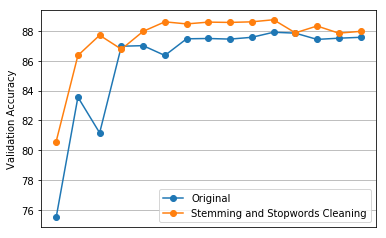

In [79]:
adam_L=plt.plot(val_acc_epochs_Adam_L, marker='o', label='Original')
adam_L_plus=plt.plot(val_acc_epochs_Adam_L_plus, marker='o', label='Stemming and Stopwords Cleaning')

plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

## Section 2 Bag of Bi-gram Model

In [81]:
# define bigram_tokenize function to tokenize input sentenses into bag of 2 words

def bigram_tokenize_plus(data):
    token_dataset = []
    bigram_tokens = []
    for i in data:
        tokens = tokenize(i)
        i_tokens = []
        # remove stopwords and stemming
        tokensFiltered = []
        for words in tokens:
            if str(words) not in Stopwords:
                words = ps.stem(words)
                tokensFiltered.append(words)
        for j in range(len(tokensFiltered)-1):
            bitokens = (tokensFiltered[j], tokensFiltered[j+1])
            bigram_tokens.append(bitokens)
            i_tokens.append(bitokens)   
        token_dataset.append(i_tokens)
    return token_dataset,bigram_tokens


In [ ]:
bi_train_data_tokens, bigram_tokens = bigram_tokenize_plus(train_data)
bi_val_data_tokens, _ = bigram_tokenize_plus(val_data)
bi_test_data_tokens, _ = bigram_tokenize_plus(test_data)
os.chdir(datadir)
pkl.dump(bi_train_data_tokens, open("bi_train_data_tokens_plus.p", "wb"))
pkl.dump(bigram_tokens, open("bigram_tokens_plus.p", "wb"))
pkl.dump(bi_val_data_tokens, open("bi_val_data_tokens_plus.p", "wb"))
pkl.dump(bi_test_data_tokens, open("bi_test_data_tokens_plus.p", "wb"))

In [83]:
'''
os.chdir(datadir)
bi_train_data_tokens = pkl.load(open("bi_train_data_tokens_plus.p", "rb"))
bigram_tokens = pkl.load(open("bigram_tokens_plus.p", "rb"))

bi_val_data_tokens = pkl.load(open("bi_val_data_tokens_plus.p", "rb"))
bi_test_data_tokens = pkl.load(open("bi_test_data_tokens_plus.p", "rb"))

In [84]:
# build bigram vocabs with size of max_vocab_size_1
bigram_token2id, bigram_vocab = build_vocab(bigram_tokens, max_vocab_size_1)

# transfer the train/validation/test dataset of tokens into indices
bi_train_data_indices = indices_dataset(bi_train_data_tokens, bigram_token2id)
bi_val_data_indices = indices_dataset(bi_val_data_tokens, bigram_token2id)
bi_test_data_indices = indices_dataset(bi_test_data_tokens, bigram_token2id)

In [86]:
# Prepare training input and target for the model
bi_train_dataset = aclImdbDataset(bi_train_data_indices, train_target)
bi_train_loader = torch.utils.data.DataLoader(dataset=bi_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_val_dataset = aclImdbDataset(bi_val_data_indices, val_target)
bi_val_loader = torch.utils.data.DataLoader(dataset=bi_val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_test_dataset = aclImdbDataset(bi_test_data_indices, test_target)
bi_test_loader = torch.utils.data.DataLoader(dataset=bi_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

### Model X

In [87]:
bigram_val_acc_epochs = []

emb_dim = 100
model = BagOfNGram(len(bigram_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.8 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(bi_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_loader, model)
            bigram_val_acc_epochs.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_loader), val_acc))

                



Epoch: [1/5], Step: [101/313], Validation Acc: 50.34
Epoch: [1/5], Step: [201/313], Validation Acc: 69.76
Epoch: [1/5], Step: [301/313], Validation Acc: 80.64
Epoch: [2/5], Step: [101/313], Validation Acc: 81.14
Epoch: [2/5], Step: [201/313], Validation Acc: 78.88
Epoch: [2/5], Step: [301/313], Validation Acc: 80.74
Epoch: [3/5], Step: [101/313], Validation Acc: 82.56
Epoch: [3/5], Step: [201/313], Validation Acc: 81.7
Epoch: [3/5], Step: [301/313], Validation Acc: 82.0
Epoch: [4/5], Step: [101/313], Validation Acc: 82.14
Epoch: [4/5], Step: [201/313], Validation Acc: 81.96
Epoch: [4/5], Step: [301/313], Validation Acc: 81.76
Epoch: [5/5], Step: [101/313], Validation Acc: 82.74
Epoch: [5/5], Step: [201/313], Validation Acc: 82.26
Epoch: [5/5], Step: [301/313], Validation Acc: 82.34


### Model XI

In [152]:
# double the vocab size
max_vocab_size_2 = 20000
bigram_token2id_L, bigram_vocab_L = build_vocab(bigram_tokens, max_vocab_size_2)
bi_train_data_indices_L = indices_dataset(bi_train_data_tokens, bigram_token2id_L)
bi_val_data_indices_L = indices_dataset(bi_val_data_tokens, bigram_token2id_L)
bi_test_data_indices_L = indices_dataset(bi_test_data_tokens, bigram_token2id_L)

In [159]:
bi_train_dataset_L = aclImdbDataset(bi_train_data_indices_L, train_target)
bi_train_loader_L = torch.utils.data.DataLoader(dataset=bi_train_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_val_dataset_L = aclImdbDataset(bi_val_data_indices_L, val_target)
bi_val_loader_L = torch.utils.data.DataLoader(dataset=bi_val_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_test_dataset_L = aclImdbDataset(bi_test_data_indices_L, test_target)
bi_test_loader_L = torch.utils.data.DataLoader(dataset=bi_test_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [160]:
os.chdir(datadir)
t0 = time.time()
bigram_val_acc_epochs_Adam_100_L_1 = []

emb_dim = 100
model = BagOfNGram(len(bigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(bi_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_loader_L, model)
            bigram_val_acc_epochs_Adam_100_L_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_loader_L), val_acc))

t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))




Epoch: [1/5], Step: [101/313], Validation Acc: 50.5
Epoch: [1/5], Step: [201/313], Validation Acc: 67.74
Epoch: [1/5], Step: [301/313], Validation Acc: 81.92
Epoch: [2/5], Step: [101/313], Validation Acc: 83.28
Epoch: [2/5], Step: [201/313], Validation Acc: 83.14
Epoch: [2/5], Step: [301/313], Validation Acc: 80.54
Epoch: [3/5], Step: [101/313], Validation Acc: 84.12
Epoch: [3/5], Step: [201/313], Validation Acc: 83.48
Epoch: [3/5], Step: [301/313], Validation Acc: 84.38
Epoch: [4/5], Step: [101/313], Validation Acc: 83.52
Epoch: [4/5], Step: [201/313], Validation Acc: 84.1
Epoch: [4/5], Step: [301/313], Validation Acc: 83.14
Epoch: [5/5], Step: [101/313], Validation Acc: 83.7
Epoch: [5/5], Step: [201/313], Validation Acc: 83.84
Epoch: [5/5], Step: [301/313], Validation Acc: 83.1
Time Elapsed:88.49860095977783


### Model XII

In [152]:
# double the vocab size again
max_vocab_size_3 = 40000
bigram_token2id_xL, bigram_vocab_xL = build_vocab(bigram_tokens, max_vocab_size_3)
bi_train_data_indices_xL = indices_dataset(bi_train_data_tokens, bigram_token2id_xL)
bi_val_data_indices_xL = indices_dataset(bi_val_data_tokens, bigram_token2id_xL)
bi_test_data_indices_xL = indices_dataset(bi_test_data_tokens, bigram_token2id_xL)

In [159]:
bi_train_dataset_xL = aclImdbDataset(bi_train_data_indices_xL, train_target)
bi_train_loader_xL = torch.utils.data.DataLoader(dataset=bi_train_dataset_xL, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_val_dataset_xL = aclImdbDataset(bi_val_data_indices_xL, val_target)
bi_val_loader_xL = torch.utils.data.DataLoader(dataset=bi_val_dataset_xL, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_test_dataset_xL = aclImdbDataset(bi_test_data_indices_xL, test_target)
bi_test_loader_xL = torch.utils.data.DataLoader(dataset=bi_test_dataset_xL, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [133]:
t0 = time.time()
bigram_val_acc_epochs_Adam_100_xL_1 = []

emb_dim = 100
model = BagOfNGram(len(bigram_token2id_xL),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(bi_train_loader_xL):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_loader_xL, model)
            bigram_val_acc_epochs_Adam_100_xL_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_loader_xL), val_acc))

t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))



Epoch: [1/5], Step: [101/313], Validation Acc: 61.66
Epoch: [1/5], Step: [201/313], Validation Acc: 72.8
Epoch: [1/5], Step: [301/313], Validation Acc: 82.24
Epoch: [2/5], Step: [101/313], Validation Acc: 81.18
Epoch: [2/5], Step: [201/313], Validation Acc: 83.32
Epoch: [2/5], Step: [301/313], Validation Acc: 83.1
Epoch: [3/5], Step: [101/313], Validation Acc: 85.26
Epoch: [3/5], Step: [201/313], Validation Acc: 85.12
Epoch: [3/5], Step: [301/313], Validation Acc: 85.38
Epoch: [4/5], Step: [101/313], Validation Acc: 85.74
Epoch: [4/5], Step: [201/313], Validation Acc: 85.44
Epoch: [4/5], Step: [301/313], Validation Acc: 85.44
Epoch: [5/5], Step: [101/313], Validation Acc: 85.36
Epoch: [5/5], Step: [201/313], Validation Acc: 85.26
Epoch: [5/5], Step: [301/313], Validation Acc: 85.4
Time Elapsed:105.58992981910706


Text(0,0.5,'Validation Accuracy')

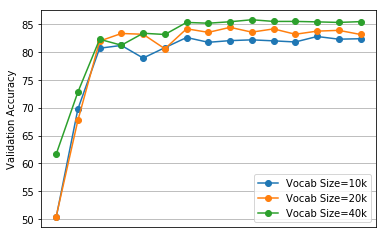

In [161]:

plt.plot(bigram_val_acc_epochs, marker='o', label='Vocab Size=10k')
plt.plot(bigram_val_acc_epochs_Adam_100_L_1, marker='o', label='Vocab Size=20k')
plt.plot(bigram_val_acc_epochs_Adam_100_xL_1, marker='o', label='Vocab Size=40k')

plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

### Model XIII

In [134]:
t0 = time.time()
bigram_val_acc_epochs_Adam_200_xL_1 = []

emb_dim = 200
model = BagOfNGram(len(bigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(bi_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_loader_L, model)
            bigram_val_acc_epochs_Adam_200_xL_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_loader_L), val_acc))

t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))


Epoch: [1/5], Step: [101/313], Validation Acc: 76.32
Epoch: [1/5], Step: [201/313], Validation Acc: 78.94
Epoch: [1/5], Step: [301/313], Validation Acc: 83.56
Epoch: [2/5], Step: [101/313], Validation Acc: 82.0
Epoch: [2/5], Step: [201/313], Validation Acc: 83.86
Epoch: [2/5], Step: [301/313], Validation Acc: 82.94
Epoch: [3/5], Step: [101/313], Validation Acc: 82.54
Epoch: [3/5], Step: [201/313], Validation Acc: 83.6
Epoch: [3/5], Step: [301/313], Validation Acc: 85.3
Epoch: [4/5], Step: [101/313], Validation Acc: 85.26
Epoch: [4/5], Step: [201/313], Validation Acc: 84.66
Epoch: [4/5], Step: [301/313], Validation Acc: 84.96
Epoch: [5/5], Step: [101/313], Validation Acc: 85.24
Epoch: [5/5], Step: [201/313], Validation Acc: 85.22
Epoch: [5/5], Step: [301/313], Validation Acc: 85.04
Time Elapsed:174.55276918411255


### Model XIV

In [132]:
t0 = time.time()
bigram_val_acc_epochs_Adam_300_xL_01 = []

emb_dim = 300
model = BagOfNGram(len(bigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(bi_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_loader_L, model)
            bigram_val_acc_epochs_Adam_300_xL_01.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_loader), val_acc))

t1 = time.time()
print('Time elapse: {}'.format(t1-t0))



Epoch: [1/5], Step: [101/313], Validation Acc: 60.88
Epoch: [1/5], Step: [201/313], Validation Acc: 75.7
Epoch: [1/5], Step: [301/313], Validation Acc: 81.72
Epoch: [2/5], Step: [101/313], Validation Acc: 83.6
Epoch: [2/5], Step: [201/313], Validation Acc: 84.2
Epoch: [2/5], Step: [301/313], Validation Acc: 83.84
Epoch: [3/5], Step: [101/313], Validation Acc: 84.58
Epoch: [3/5], Step: [201/313], Validation Acc: 85.32
Epoch: [3/5], Step: [301/313], Validation Acc: 85.68
Epoch: [4/5], Step: [101/313], Validation Acc: 84.62
Epoch: [4/5], Step: [201/313], Validation Acc: 84.66
Epoch: [4/5], Step: [301/313], Validation Acc: 85.28
Epoch: [5/5], Step: [101/313], Validation Acc: 81.8
Epoch: [5/5], Step: [201/313], Validation Acc: 84.96
Epoch: [5/5], Step: [301/313], Validation Acc: 85.18
Time elapse: 242.99939465522766


Text(0,0.5,'Validation Accuracy')

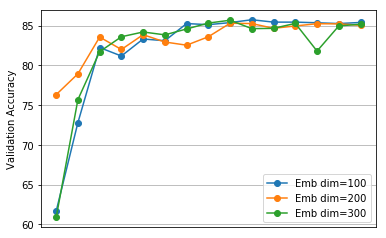

In [135]:

plt.plot(bigram_val_acc_epochs_Adam_100_xL_1, marker='o', label='Emb dim=100')
plt.plot(bigram_val_acc_epochs_Adam_200_xL_1, marker='o', label='Emb dim=200')
plt.plot(bigram_val_acc_epochs_Adam_300_xL_01, marker='o', label='Emb dim=300')


plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
#plt.title('Training Curve of 5 Epochs with Learning Rate Scheduler')

## Section 3 Bag of Tri-gram Model

In [103]:
def trigram_tokenize_plus(data):
    token_dataset = []
    trigram_tokens = []
    for i in data:
        tokens = tokenize(i)
        i_tokens = []
        # remove stopwords and stemming
        tokensFiltered = []
        for words in tokens:
            if str(words) not in Stopwords:
                words = ps.stem(words)
                tokensFiltered.append(words)
        for j in range(len(tokensFiltered)-2):
            tritokens = (tokensFiltered[j], tokensFiltered[j+1], tokensFiltered[j+2])
            trigram_tokens.append(tritokens)
            i_tokens.append(tritokens)   
        token_dataset.append(i_tokens)
    return token_dataset,trigram_tokens

In [104]:
tri_train_data_tokens, trigram_tokens = trigram_tokenize_plus(train_data)
tri_val_data_tokens, _ = trigram_tokenize_plus(val_data)
tri_test_data_tokens, _ = trigram_tokenize_plus(test_data)

os.chdir(datadir)
pkl.dump(tri_train_data_tokens, open("tri_train_data_tokens_plus.p", "wb"))
pkl.dump(trigram_tokens, open("trigram_tokens_plus.p", "wb"))
pkl.dump(tri_val_data_tokens, open("tri_val_data_tokens_plus.p", "wb"))
pkl.dump(tri_test_data_tokens, open("tri_test_data_tokens_plus.p", "wb"))


### Model XIII

In [109]:
trigram_token2id, trigram_vocab = build_vocab(trigram_tokens, max_vocab_size_1)
tri_train_data_indices = indices_dataset(tri_train_data_tokens, trigram_token2id)
tri_val_data_indices = indices_dataset(tri_val_data_tokens, trigram_token2id)
tri_test_data_indices = indices_dataset(tri_test_data_tokens, trigram_token2id)

tri_train_dataset = aclImdbDataset(tri_train_data_indices, train_target)
tri_train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

tri_val_dataset = aclImdbDataset(tri_val_data_indices, val_target)
tri_val_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

tri_test_dataset = aclImdbDataset(tri_test_data_indices, test_target)
tri_test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [113]:
t0 = time.time()
trigram_val_acc_epochs_Adam_1 = []

emb_dim = 100
model = BagOfNGram(len(trigram_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader, model)
            trigram_val_acc_epochs_Adam_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader), val_acc))

t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))


Epoch: [1/5], Step: [101/313], Validation Acc: 51.64
Epoch: [1/5], Step: [201/313], Validation Acc: 49.98
Epoch: [1/5], Step: [301/313], Validation Acc: 56.06
Epoch: [2/5], Step: [101/313], Validation Acc: 61.18
Epoch: [2/5], Step: [201/313], Validation Acc: 70.0
Epoch: [2/5], Step: [301/313], Validation Acc: 65.48
Epoch: [3/5], Step: [101/313], Validation Acc: 68.76
Epoch: [3/5], Step: [201/313], Validation Acc: 71.14
Epoch: [3/5], Step: [301/313], Validation Acc: 71.14
Epoch: [4/5], Step: [101/313], Validation Acc: 68.2
Epoch: [4/5], Step: [201/313], Validation Acc: 71.54
Epoch: [4/5], Step: [301/313], Validation Acc: 70.28
Epoch: [5/5], Step: [101/313], Validation Acc: 72.12
Epoch: [5/5], Step: [201/313], Validation Acc: 72.58
Epoch: [5/5], Step: [301/313], Validation Acc: 72.66
Time Elapsed:125.52675890922546


### Model XIV

In [148]:
max_vocab_size_3 = 9 * max_vocab_size_1
trigram_token2id_L, trigram_vocab_L = build_vocab(trigram_tokens, max_vocab_size_3)
tri_train_data_indices_L = indices_dataset(tri_train_data_tokens, trigram_token2id_L)
tri_val_data_indices_L = indices_dataset(tri_val_data_tokens, trigram_token2id_L)
tri_test_data_indices_L = indices_dataset(tri_test_data_tokens, trigram_token2id_L)

tri_train_dataset_L = aclImdbDataset(tri_train_data_indices_L, train_target)
tri_train_loader_L = torch.utils.data.DataLoader(dataset=tri_train_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

tri_val_dataset_L = aclImdbDataset(tri_val_data_indices_L, val_target)
tri_val_loader_L = torch.utils.data.DataLoader(dataset=tri_val_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

tri_test_dataset_L = aclImdbDataset(tri_test_data_indices_L, test_target)
tri_test_loader_L = torch.utils.data.DataLoader(dataset=tri_test_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [149]:
t0 = time.time()
trigram_val_acc_epochs_Adam_L = []

emb_dim = 100
model = BagOfNGram(len(trigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.70 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader_L, model)
            trigram_val_acc_epochs_Adam_L.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader_L), val_acc))


t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 49.9
Epoch: [1/5], Step: [201/313], Validation Acc: 50.02
Epoch: [1/5], Step: [301/313], Validation Acc: 56.14
Epoch: [2/5], Step: [101/313], Validation Acc: 60.44
Epoch: [2/5], Step: [201/313], Validation Acc: 65.28
Epoch: [2/5], Step: [301/313], Validation Acc: 71.78
Epoch: [3/5], Step: [101/313], Validation Acc: 72.52
Epoch: [3/5], Step: [201/313], Validation Acc: 65.42
Epoch: [3/5], Step: [301/313], Validation Acc: 75.14
Epoch: [4/5], Step: [101/313], Validation Acc: 75.06
Epoch: [4/5], Step: [201/313], Validation Acc: 73.5
Epoch: [4/5], Step: [301/313], Validation Acc: 74.78
Epoch: [5/5], Step: [101/313], Validation Acc: 73.7
Epoch: [5/5], Step: [201/313], Validation Acc: 74.26
Epoch: [5/5], Step: [301/313], Validation Acc: 73.98
Time Elapsed:184.7683048248291


Text(0,0.5,'Validation Accuracy')

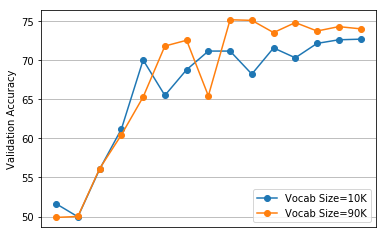

In [173]:
plt.plot(trigram_val_acc_epochs_Adam_1, marker='o', label='Vocab Size=10K')
plt.plot(trigram_val_acc_epochs_Adam_L, marker='o', label='Vocab Size=90K')



plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')


### Model XV

In [150]:
t0 = time.time()
trigram_val_acc_epochs_Adam_L_200 = []

emb_dim = 200
model = BagOfNGram(len(trigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader_L, model)
            trigram_val_acc_epochs_Adam_L_200.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader_L), val_acc))


t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 56.52
Epoch: [1/5], Step: [201/313], Validation Acc: 61.8
Epoch: [1/5], Step: [301/313], Validation Acc: 50.02
Epoch: [2/5], Step: [101/313], Validation Acc: 70.2
Epoch: [2/5], Step: [201/313], Validation Acc: 67.64
Epoch: [2/5], Step: [301/313], Validation Acc: 65.76
Epoch: [3/5], Step: [101/313], Validation Acc: 70.0
Epoch: [3/5], Step: [201/313], Validation Acc: 69.94
Epoch: [3/5], Step: [301/313], Validation Acc: 72.78
Epoch: [4/5], Step: [101/313], Validation Acc: 73.88
Epoch: [4/5], Step: [201/313], Validation Acc: 73.58
Epoch: [4/5], Step: [301/313], Validation Acc: 75.6
Epoch: [5/5], Step: [101/313], Validation Acc: 72.58
Epoch: [5/5], Step: [201/313], Validation Acc: 75.0
Epoch: [5/5], Step: [301/313], Validation Acc: 73.66
Time Elapsed:326.5444359779358


### Model XVI

In [151]:
t0 = time.time()
trigram_val_acc_epochs_Adam_L_400 = []

emb_dim = 400
model = BagOfNGram(len(trigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.9 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader_L, model)
            trigram_val_acc_epochs_Adam_L_400.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader_L), val_acc))


t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))

Epoch: [1/5], Step: [101/313], Validation Acc: 50.8
Epoch: [1/5], Step: [201/313], Validation Acc: 51.46
Epoch: [1/5], Step: [301/313], Validation Acc: 50.14
Epoch: [2/5], Step: [101/313], Validation Acc: 62.98
Epoch: [2/5], Step: [201/313], Validation Acc: 69.4
Epoch: [2/5], Step: [301/313], Validation Acc: 73.7
Epoch: [3/5], Step: [101/313], Validation Acc: 74.92
Epoch: [3/5], Step: [201/313], Validation Acc: 72.8
Epoch: [3/5], Step: [301/313], Validation Acc: 61.44
Epoch: [4/5], Step: [101/313], Validation Acc: 74.04
Epoch: [4/5], Step: [201/313], Validation Acc: 74.26
Epoch: [4/5], Step: [301/313], Validation Acc: 74.84
Epoch: [5/5], Step: [101/313], Validation Acc: 74.14
Epoch: [5/5], Step: [201/313], Validation Acc: 66.7
Epoch: [5/5], Step: [301/313], Validation Acc: 73.88
Time Elapsed:684.9529981613159


Text(0,0.5,'Validation Accuracy')

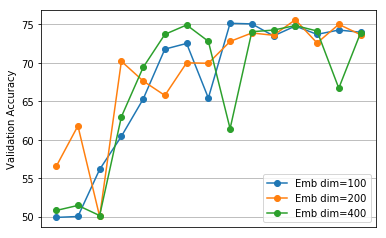

In [186]:
plt.plot(trigram_val_acc_epochs_Adam_L, marker='o', label='Emb dim=100')
plt.plot(trigram_val_acc_epochs_Adam_L_200, marker='o', label='Emb dim=200')
plt.plot(trigram_val_acc_epochs_Adam_L_400, marker='o', label='Emb dim=400')



plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')

### Model XVII

In [174]:
BATCH_SIZE_2 = 100
tri_train_loader_new = torch.utils.data.DataLoader(dataset=tri_train_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

tri_val_loader_new = torch.utils.data.DataLoader(dataset=tri_val_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

tri_test_loader_new = torch.utils.data.DataLoader(dataset=tri_test_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

In [187]:
t0 = time.time()
trigram_val_acc_epochs_Adam_new = []

emb_dim = 200
model = BagOfNGram(len(trigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader_new):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader_new, model)
            trigram_val_acc_epochs_Adam_new.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader_new), val_acc))



t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))

Epoch: [1/5], Step: [101/200], Validation Acc: 50.0
Epoch: [2/5], Step: [101/200], Validation Acc: 61.4
Epoch: [3/5], Step: [101/200], Validation Acc: 67.52
Epoch: [4/5], Step: [101/200], Validation Acc: 75.02
Epoch: [5/5], Step: [101/200], Validation Acc: 72.9
Time Elapsed:210.5759699344635


### Model XVIII

In [176]:
BATCH_SIZE_3 = 32
tri_train_loader_new3 = torch.utils.data.DataLoader(dataset=tri_train_dataset_L, batch_size=BATCH_SIZE_3, collate_fn=collate_func,shuffle=True)

tri_val_loader_new3 = torch.utils.data.DataLoader(dataset=tri_val_dataset_L, batch_size=BATCH_SIZE_3, collate_fn=collate_func,shuffle=True)

tri_test_loader_new3 = torch.utils.data.DataLoader(dataset=tri_test_dataset_L, batch_size=BATCH_SIZE_3, collate_fn=collate_func,shuffle=True)

In [188]:
t0 = time.time()
trigram_val_acc_epochs_Adam_new3 = []

emb_dim = 200
model = BagOfNGram(len(trigram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(tri_train_loader_new3):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(tri_val_loader_new3, model)
            trigram_val_acc_epochs_Adam_new3.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(tri_train_loader_new3), val_acc))



t1 = time.time()
print('Time Elapsed:{}'.format(t1-t0))

Epoch: [1/5], Step: [101/625], Validation Acc: 50.04
Epoch: [1/5], Step: [201/625], Validation Acc: 51.06
Epoch: [1/5], Step: [301/625], Validation Acc: 51.62
Epoch: [1/5], Step: [401/625], Validation Acc: 50.02
Epoch: [1/5], Step: [501/625], Validation Acc: 52.18
Epoch: [1/5], Step: [601/625], Validation Acc: 50.86
Epoch: [2/5], Step: [101/625], Validation Acc: 63.26
Epoch: [2/5], Step: [201/625], Validation Acc: 71.08
Epoch: [2/5], Step: [301/625], Validation Acc: 66.48
Epoch: [2/5], Step: [401/625], Validation Acc: 61.64
Epoch: [2/5], Step: [501/625], Validation Acc: 63.7
Epoch: [2/5], Step: [601/625], Validation Acc: 73.42
Epoch: [3/5], Step: [101/625], Validation Acc: 75.16
Epoch: [3/5], Step: [201/625], Validation Acc: 73.78
Epoch: [3/5], Step: [301/625], Validation Acc: 71.66
Epoch: [3/5], Step: [401/625], Validation Acc: 73.46
Epoch: [3/5], Step: [501/625], Validation Acc: 68.48
Epoch: [3/5], Step: [601/625], Validation Acc: 72.8
Epoch: [4/5], Step: [101/625], Validation Acc: 7

Text(0,0.5,'Validation Accuracy')

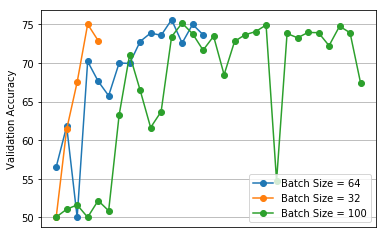

In [192]:
plt.plot(trigram_val_acc_epochs_Adam_L_200, marker='o', label='Batch Size = 64')
plt.plot(trigram_val_acc_epochs_Adam_new, marker='o', label='Batch Size = 32')
plt.plot(trigram_val_acc_epochs_Adam_new3, marker='o', label='Batch Size = 100')



plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')

In [249]:
def count1s(dataset):
    count = 0
    for i in dataset:
        count += i.count(1)
    return count
print(count1s(tri_train_data_indices))
print(count1s(bi_train_data_indices))
print(count1s(mono_train_data_indices))

3407133
2679533
295242


## Section 4 Bag of Quad-gram Model

In [105]:
def quadgram_tokenize_plus(data):
    token_dataset = []
    quadgram_tokens = []
    for i in data:
        tokens = tokenize(i)
        i_tokens = []
        # remove stopwords and stemming
        tokensFiltered = []
        for words in tokens:
            if str(words) not in Stopwords:
                words = ps.stem(words)
                tokensFiltered.append(words)
        for j in range(len(tokensFiltered)-3):
            quadtokens = (tokensFiltered[j], tokensFiltered[j+1], tokensFiltered[j+2],tokensFiltered[j+3])
            quadgram_tokens.append(quadtokens)
            i_tokens.append(quadtokens)   
        token_dataset.append(i_tokens)
    return token_dataset,quadgram_tokens

In [106]:

quad_train_data_tokens, quadgram_tokens = quadgram_tokenize_plus(train_data)
quad_val_data_tokens, _ = quadgram_tokenize_plus(val_data)
quad_test_data_tokens, _ = quadgram_tokenize_plus(test_data)

os.chdir(datadir)
pkl.dump(quad_train_data_tokens, open("quad_train_data_tokens_plus.p", "wb"))
pkl.dump(quadgram_tokens, open("quadgram_tokens_plus.p", "wb"))
pkl.dump(quad_val_data_tokens, open("quad_val_data_tokens_plus.p", "wb"))
pkl.dump(quad_test_data_tokens, open("quad_test_data_tokens_plus.p", "wb"))


### Model XIX

In [138]:
quadgram_token2id, quadgram_vocab = build_vocab(quadgram_tokens, max_vocab_size_1)
quad_train_data_indices = indices_dataset(quad_train_data_tokens, quadgram_token2id)
quad_val_data_indices = indices_dataset(quad_val_data_tokens, quadgram_token2id)
quad_test_data_indices = indices_dataset(quad_test_data_tokens, quadgram_token2id)

quad_train_dataset = aclImdbDataset(quad_train_data_indices, train_target)
quad_train_loader = torch.utils.data.DataLoader(dataset=quad_train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

quad_val_dataset = aclImdbDataset(quad_val_data_indices, val_target)
quad_val_loader = torch.utils.data.DataLoader(dataset=quad_val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

quad_test_dataset = aclImdbDataset(quad_test_data_indices, test_target)
quad_test_loader = torch.utils.data.DataLoader(dataset=quad_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [163]:
t0 = time.time()
quadgram_val_acc_epochs_Adam_01 = []

emb_dim = 100
model = BagOfNGram(len(quadgram_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(quad_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(quad_val_loader, model)
            quadgram_val_acc_epochs_Adam_01.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(quad_train_loader), val_acc))


t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))


Epoch: [1/5], Step: [101/313], Validation Acc: 50.46
Epoch: [1/5], Step: [201/313], Validation Acc: 50.0
Epoch: [1/5], Step: [301/313], Validation Acc: 50.0
Epoch: [2/5], Step: [101/313], Validation Acc: 50.28
Epoch: [2/5], Step: [201/313], Validation Acc: 50.82
Epoch: [2/5], Step: [301/313], Validation Acc: 52.4
Epoch: [3/5], Step: [101/313], Validation Acc: 53.64
Epoch: [3/5], Step: [201/313], Validation Acc: 51.08
Epoch: [3/5], Step: [301/313], Validation Acc: 51.96
Epoch: [4/5], Step: [101/313], Validation Acc: 54.06
Epoch: [4/5], Step: [201/313], Validation Acc: 53.92
Epoch: [4/5], Step: [301/313], Validation Acc: 55.62
Epoch: [5/5], Step: [101/313], Validation Acc: 59.56
Epoch: [5/5], Step: [201/313], Validation Acc: 53.08
Epoch: [5/5], Step: [301/313], Validation Acc: 56.54
Time elapse: 74.06398415565491


### Model XX

In [181]:
quadgram_token2id_L, quadgram_vocab_L = build_vocab(quadgram_tokens, max_vocab_size_1*16)

quad_train_data_indices_L = indices_dataset(quad_train_data_tokens, quadgram_token2id_L)
quad_val_data_indices_L = indices_dataset(quad_val_data_tokens, quadgram_token2id_L)
quad_test_data_indices_L = indices_dataset(quad_test_data_tokens, quadgram_token2id_L)

quad_train_dataset_L = aclImdbDataset(quad_train_data_indices_L, train_target)
quad_train_loader_L = torch.utils.data.DataLoader(dataset=quad_train_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

quad_val_dataset_L = aclImdbDataset(quad_val_data_indices_L, val_target)
quad_val_loader_L = torch.utils.data.DataLoader(dataset=quad_val_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

quad_test_dataset_L = aclImdbDataset(quad_test_data_indices_L, test_target)
quad_test_loader_L = torch.utils.data.DataLoader(dataset=quad_test_dataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [189]:
t0 = time.time()
quadgram_val_acc_epochs_Adam_01_L = []

emb_dim = 400
model = BagOfNGram(len(quadgram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(quad_train_loader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(quad_val_loader_L, model)
            quadgram_val_acc_epochs_Adam_01_L.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(quad_train_loader_L), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))






Epoch: [1/5], Step: [101/313], Validation Acc: 51.34
Epoch: [1/5], Step: [201/313], Validation Acc: 50.02
Epoch: [1/5], Step: [301/313], Validation Acc: 50.04
Epoch: [2/5], Step: [101/313], Validation Acc: 50.18
Epoch: [2/5], Step: [201/313], Validation Acc: 51.44
Epoch: [2/5], Step: [301/313], Validation Acc: 52.18
Epoch: [3/5], Step: [101/313], Validation Acc: 52.66
Epoch: [3/5], Step: [201/313], Validation Acc: 51.66
Epoch: [3/5], Step: [301/313], Validation Acc: 52.34
Epoch: [4/5], Step: [101/313], Validation Acc: 58.66
Epoch: [4/5], Step: [201/313], Validation Acc: 56.82
Epoch: [4/5], Step: [301/313], Validation Acc: 56.52
Epoch: [5/5], Step: [101/313], Validation Acc: 59.04
Epoch: [5/5], Step: [201/313], Validation Acc: 60.52
Epoch: [5/5], Step: [301/313], Validation Acc: 54.72
Time elapse: 1166.212280035019


Text(0,0.5,'Validation Accuracy')

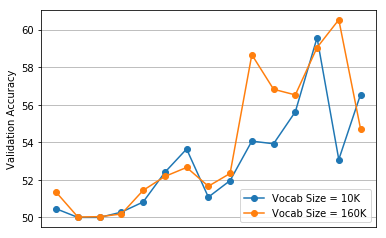

In [191]:
plt.plot(quadgram_val_acc_epochs_Adam_01, marker='o', label='Vocab Size = 10K')
plt.plot(quadgram_val_acc_epochs_Adam_01_L, marker='o', label='Vocab Size = 160K')




plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')

### Model XXI

In [165]:

quad_train_data_indices_L = indices_dataset(quad_train_data_tokens, quadgram_token2id_L)
quad_val_data_indices_L = indices_dataset(quad_val_data_tokens, quadgram_token2id_L)
quad_test_data_indices_L = indices_dataset(quad_test_data_tokens, quadgram_token2id_L)

quad_train_dataset_L = aclImdbDataset(quad_train_data_indices_L, train_target)
quad_train_loader_new = torch.utils.data.DataLoader(dataset=quad_train_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

quad_val_dataset_L = aclImdbDataset(quad_val_data_indices_L, val_target)
quad_val_loader_new = torch.utils.data.DataLoader(dataset=quad_val_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

quad_test_dataset_L = aclImdbDataset(quad_test_data_indices_L, test_target)
quad_test_loader_new = torch.utils.data.DataLoader(dataset=quad_test_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

In [169]:
t0 = time.time()
quadgram_val_acc_epochs_Adam_01_L_new = []

emb_dim = 400
model = BagOfNGram(len(quadgram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(quad_train_loader_new):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(quad_val_loader_new, model)
            quadgram_val_acc_epochs_Adam_01_L_new.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(quad_train_loader_new), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))




Epoch: [1/5], Step: [101/200], Validation Acc: 50.96
Epoch: [2/5], Step: [101/200], Validation Acc: 50.02
Epoch: [3/5], Step: [101/200], Validation Acc: 50.2
Epoch: [4/5], Step: [101/200], Validation Acc: 58.82
Epoch: [5/5], Step: [101/200], Validation Acc: 59.64
Time elapse: 780.3370809555054


### Model XXII

In [172]:
quadgram_token2id_L, quadgram_vocab_L = build_vocab(quadgram_tokens, max_vocab_size_1*16)
quad_train_data_indices_L = indices_dataset(quad_train_data_tokens, quadgram_token2id_L)
quad_val_data_indices_L = indices_dataset(quad_val_data_tokens, quadgram_token2id_L)
quad_test_data_indices_L = indices_dataset(quad_test_data_tokens, quadgram_token2id_L)

quad_train_dataset_L = aclImdbDataset(quad_train_data_indices_L, train_target)
quad_train_loader_new3 = torch.utils.data.DataLoader(dataset=quad_train_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

quad_val_dataset_L = aclImdbDataset(quad_val_data_indices_L, val_target)
quad_val_loader_new3 = torch.utils.data.DataLoader(dataset=quad_val_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

quad_test_dataset_L = aclImdbDataset(quad_test_data_indices_L, test_target)
quad_test_loader_new3 = torch.utils.data.DataLoader(dataset=quad_test_dataset_L, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

In [171]:
t0 = time.time()
quadgram_val_acc_epochs_Adam_01_L_new3 = []

emb_dim = 400
model = BagOfNGram(len(quadgram_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lambda1 = lambda epoch: 0.90 ** epoch
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(quad_train_loader_new3):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(quad_val_loader_new3, model)
            quadgram_val_acc_epochs_Adam_01_L_new3.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(quad_train_loader_new3), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))





Epoch: [1/5], Step: [101/625], Validation Acc: 50.0
Epoch: [1/5], Step: [201/625], Validation Acc: 50.02
Epoch: [1/5], Step: [301/625], Validation Acc: 50.0
Epoch: [1/5], Step: [401/625], Validation Acc: 49.36
Epoch: [1/5], Step: [501/625], Validation Acc: 50.84
Epoch: [1/5], Step: [601/625], Validation Acc: 50.06
Epoch: [2/5], Step: [101/625], Validation Acc: 51.24
Epoch: [2/5], Step: [201/625], Validation Acc: 51.16
Epoch: [2/5], Step: [301/625], Validation Acc: 51.4
Epoch: [2/5], Step: [401/625], Validation Acc: 52.84
Epoch: [2/5], Step: [501/625], Validation Acc: 50.88
Epoch: [2/5], Step: [601/625], Validation Acc: 53.16
Epoch: [3/5], Step: [101/625], Validation Acc: 52.5
Epoch: [3/5], Step: [201/625], Validation Acc: 54.78
Epoch: [3/5], Step: [301/625], Validation Acc: 51.98
Epoch: [3/5], Step: [401/625], Validation Acc: 53.38
Epoch: [3/5], Step: [501/625], Validation Acc: 58.56
Epoch: [3/5], Step: [601/625], Validation Acc: 55.44
Epoch: [4/5], Step: [101/625], Validation Acc: 56.

Text(0,0.5,'Validation Accuracy')

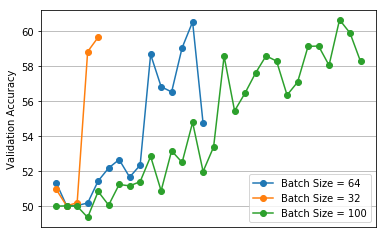

In [190]:
plt.plot(quadgram_val_acc_epochs_Adam_01_L, marker='o', label='Batch Size = 64')
plt.plot(quadgram_val_acc_epochs_Adam_01_L_new, marker='o', label='Batch Size = 32')
plt.plot(quadgram_val_acc_epochs_Adam_01_L_new3, marker='o', label='Batch Size = 100')



plt.legend(loc=4)
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')

## Deployment for Model IX on the Test Set

In [215]:
print('Test Set Accuracy: {}'.format(test_model(mono_test_loader_plus, model)))

Test Set Accuracy: 86.044


## Section 5 Bonus

## Model XXIII

In [221]:
BATCH_SIZE = 64
mono_train_scoredataset = aclImdbDataset(mono_train_data_indices, train_scoretarget)
mono_train_scoreloader = torch.utils.data.DataLoader(dataset=mono_train_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_val_scoredataset = aclImdbDataset(mono_val_data_indices, val_scoretarget)
mono_val_scoreloader = torch.utils.data.DataLoader(dataset=mono_val_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_test_scoredataset = aclImdbDataset(mono_test_data_indices, test_scoretarget)
mono_test_scoreloader = torch.utils.data.DataLoader(dataset=mono_test_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [222]:
t0 = time.time()
scoreval_acc_epochs_Adam_1 = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 6
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_scoreloader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_scoreloader, model)
            scoreval_acc_epochs_Adam_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_scoreloader), val_acc))

t1 = time.time()
print('Time Elapsed: {}'.format(t1-t0))



Epoch: [1/6], Step: [101/313], Validation Acc: 22.64
Epoch: [1/6], Step: [201/313], Validation Acc: 33.36
Epoch: [1/6], Step: [301/313], Validation Acc: 36.8
Epoch: [2/6], Step: [101/313], Validation Acc: 38.54
Epoch: [2/6], Step: [201/313], Validation Acc: 39.92
Epoch: [2/6], Step: [301/313], Validation Acc: 39.3
Epoch: [3/6], Step: [101/313], Validation Acc: 40.7
Epoch: [3/6], Step: [201/313], Validation Acc: 40.26
Epoch: [3/6], Step: [301/313], Validation Acc: 40.74
Epoch: [4/6], Step: [101/313], Validation Acc: 40.16
Epoch: [4/6], Step: [201/313], Validation Acc: 39.12
Epoch: [4/6], Step: [301/313], Validation Acc: 39.52
Epoch: [5/6], Step: [101/313], Validation Acc: 39.22
Epoch: [5/6], Step: [201/313], Validation Acc: 39.16
Epoch: [5/6], Step: [301/313], Validation Acc: 38.52
Epoch: [6/6], Step: [101/313], Validation Acc: 39.74
Epoch: [6/6], Step: [201/313], Validation Acc: 39.24
Epoch: [6/6], Step: [301/313], Validation Acc: 37.3
Time Elapsed: 98.40795302391052


## Model XXIV

In [223]:


BATCH_SIZE_2 = 32

mono_train_scoreloader_new = torch.utils.data.DataLoader(dataset=mono_train_scoredataset, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)
mono_val_scoreloader_new = torch.utils.data.DataLoader(dataset=mono_val_scoredataset, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)
mono_test_scoreloader_new = torch.utils.data.DataLoader(dataset=mono_test_scoredataset, batch_size=BATCH_SIZE_2, collate_fn=collate_func,shuffle=True)

In [224]:
t0 = time.time()
scoreval_acc_epochs_Adam_1_new = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 6
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_scoreloader_new):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_scoreloader_new, model)
            scoreval_acc_epochs_Adam_1_new.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_scoreloader_new), val_acc))

t1 = time.time()
print('Time Elapsed: {}'.format(t1-t0))




Epoch: [1/6], Step: [101/625], Validation Acc: 25.72
Epoch: [1/6], Step: [201/625], Validation Acc: 32.46
Epoch: [1/6], Step: [301/625], Validation Acc: 36.06
Epoch: [1/6], Step: [401/625], Validation Acc: 37.34
Epoch: [1/6], Step: [501/625], Validation Acc: 36.6
Epoch: [1/6], Step: [601/625], Validation Acc: 38.9
Epoch: [2/6], Step: [101/625], Validation Acc: 39.32
Epoch: [2/6], Step: [201/625], Validation Acc: 39.54
Epoch: [2/6], Step: [301/625], Validation Acc: 39.72
Epoch: [2/6], Step: [401/625], Validation Acc: 41.16
Epoch: [2/6], Step: [501/625], Validation Acc: 41.16
Epoch: [2/6], Step: [601/625], Validation Acc: 40.56
Epoch: [3/6], Step: [101/625], Validation Acc: 40.76
Epoch: [3/6], Step: [201/625], Validation Acc: 40.98
Epoch: [3/6], Step: [301/625], Validation Acc: 40.66
Epoch: [3/6], Step: [401/625], Validation Acc: 40.52
Epoch: [3/6], Step: [501/625], Validation Acc: 40.06
Epoch: [3/6], Step: [601/625], Validation Acc: 39.74
Epoch: [4/6], Step: [101/625], Validation Acc: 4

### Model XXV

In [225]:
mono_train_scoredataset_L = aclImdbDataset(mono_train_data_indices_L, train_scoretarget)
mono_train_scoreloader_L = torch.utils.data.DataLoader(dataset=mono_train_scoredataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_val_scoredataset_L = aclImdbDataset(mono_val_data_indices_L, val_scoretarget)
mono_val_scoreloader_L = torch.utils.data.DataLoader(dataset=mono_val_scoredataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

mono_test_scoredataset_L = aclImdbDataset(mono_test_data_indices_L, test_scoretarget)
mono_test_scoreloader_L = torch.utils.data.DataLoader(dataset=mono_test_scoredataset_L, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [226]:
t0 = time.time()
scoreval_acc_epochs_Adam_L = []

emb_dim = 100
model = BagOfNGram(len(BOW_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_scoreloader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_scoreloader_L, model)
            scoreval_acc_epochs_Adam_L.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_scoreloader_L), val_acc))

t1 = time.time()
print('Time Elapsed: {}'.format(t1-t0))





Epoch: [1/10], Step: [101/313], Validation Acc: 30.28
Epoch: [1/10], Step: [201/313], Validation Acc: 33.38
Epoch: [1/10], Step: [301/313], Validation Acc: 38.36
Epoch: [2/10], Step: [101/313], Validation Acc: 37.96
Epoch: [2/10], Step: [201/313], Validation Acc: 40.42
Epoch: [2/10], Step: [301/313], Validation Acc: 40.94
Epoch: [3/10], Step: [101/313], Validation Acc: 41.36
Epoch: [3/10], Step: [201/313], Validation Acc: 40.72
Epoch: [3/10], Step: [301/313], Validation Acc: 41.3
Epoch: [4/10], Step: [101/313], Validation Acc: 39.7
Epoch: [4/10], Step: [201/313], Validation Acc: 40.0
Epoch: [4/10], Step: [301/313], Validation Acc: 41.3
Epoch: [5/10], Step: [101/313], Validation Acc: 40.72
Epoch: [5/10], Step: [201/313], Validation Acc: 39.34
Epoch: [5/10], Step: [301/313], Validation Acc: 38.7
Epoch: [6/10], Step: [101/313], Validation Acc: 37.62
Epoch: [6/10], Step: [201/313], Validation Acc: 38.36
Epoch: [6/10], Step: [301/313], Validation Acc: 38.48
Epoch: [7/10], Step: [101/313], V

### Model XXVI

In [227]:
class BagOfNGram_2(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BagOfNGram_2, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim,128)
        self.linear2 = nn.Linear(128,128)
    
    def forward(self, data, length):
        out = self.embeddings(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        out = F.relu(self.linear1(out.float()))
        out = self.linear2(out.float())
        return out

In [228]:
t0 = time.time()
scoreval_2_acc_epochs_Adam_L_200 = []

emb_dim = 200
model = BagOfNGram_2(len(BOW_token2id_L),emb_dim)
learning_rate = 0.01
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(mono_train_scoreloader_L):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(mono_val_scoreloader_L, model)
            scoreval_2_acc_epochs_Adam_L_200.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(mono_train_scoreloader_L), val_acc))

t1 = time.time()
print('Time Elapsed: {}'.format(t1-t0))







Epoch: [1/10], Step: [101/313], Validation Acc: 30.0
Epoch: [1/10], Step: [201/313], Validation Acc: 36.18
Epoch: [1/10], Step: [301/313], Validation Acc: 39.3
Epoch: [2/10], Step: [101/313], Validation Acc: 38.54
Epoch: [2/10], Step: [201/313], Validation Acc: 40.08
Epoch: [2/10], Step: [301/313], Validation Acc: 38.28
Epoch: [3/10], Step: [101/313], Validation Acc: 39.14
Epoch: [3/10], Step: [201/313], Validation Acc: 38.14
Epoch: [3/10], Step: [301/313], Validation Acc: 38.68
Epoch: [4/10], Step: [101/313], Validation Acc: 37.86
Epoch: [4/10], Step: [201/313], Validation Acc: 35.68
Epoch: [4/10], Step: [301/313], Validation Acc: 37.9
Epoch: [5/10], Step: [101/313], Validation Acc: 38.36
Epoch: [5/10], Step: [201/313], Validation Acc: 37.3
Epoch: [5/10], Step: [301/313], Validation Acc: 36.4
Epoch: [6/10], Step: [101/313], Validation Acc: 36.12
Epoch: [6/10], Step: [201/313], Validation Acc: 35.76
Epoch: [6/10], Step: [301/313], Validation Acc: 35.94
Epoch: [7/10], Step: [101/313], V

### Model XXVII

In [229]:
bi_train_scoredataset = aclImdbDataset(bi_train_data_indices, train_scoretarget)
bi_train_scoreloader = torch.utils.data.DataLoader(dataset=bi_train_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_val_scoredataset = aclImdbDataset(bi_val_data_indices, val_scoretarget)
bi_val_scoreloader = torch.utils.data.DataLoader(dataset=bi_val_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

bi_test_scoredataset = aclImdbDataset(bi_test_data_indices, test_scoretarget)
bi_test_scoreloader = torch.utils.data.DataLoader(dataset=bi_test_scoredataset, batch_size=BATCH_SIZE, collate_fn=collate_func,shuffle=True)

In [230]:
bigram_val_acc_epochs = []

emb_dim = 200
model = BagOfNGram(len(bigram_token2id),emb_dim)
learning_rate = 0.01
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(bi_train_scoreloader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        if i > 0 and i % 100 == 0:
            val_acc = test_model(bi_val_scoreloader, model)
            bigram_val_acc_epochs.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(bi_train_scoreloader), val_acc))

                





Epoch: [1/5], Step: [101/313], Validation Acc: 12.42
Epoch: [1/5], Step: [201/313], Validation Acc: 22.84
Epoch: [1/5], Step: [301/313], Validation Acc: 28.08
Epoch: [2/5], Step: [101/313], Validation Acc: 31.84
Epoch: [2/5], Step: [201/313], Validation Acc: 31.96
Epoch: [2/5], Step: [301/313], Validation Acc: 33.36
Epoch: [3/5], Step: [101/313], Validation Acc: 34.54
Epoch: [3/5], Step: [201/313], Validation Acc: 35.5
Epoch: [3/5], Step: [301/313], Validation Acc: 36.82
Epoch: [4/5], Step: [101/313], Validation Acc: 36.42
Epoch: [4/5], Step: [201/313], Validation Acc: 35.2
Epoch: [4/5], Step: [301/313], Validation Acc: 34.32
Epoch: [5/5], Step: [101/313], Validation Acc: 36.56
Epoch: [5/5], Step: [201/313], Validation Acc: 34.06
Epoch: [5/5], Step: [301/313], Validation Acc: 33.2
